# Import Core Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import pickle

from os import listdir, walk
from os.path import isfile, join

In [3]:
from detect_peaks import detect_peaks
import ruptures as rpt

# Load Dataset

In [4]:
%run load_dataset.ipynb

In [5]:
subj_range = np.hstack((np.arange(1001,1013),np.arange(2002,2003)))

all_subjects = [str(i) for i in subj_range]

In [6]:
subj_range = np.hstack((np.arange(2001,2002),np.arange(3001,3006)))

all_patients = [str(i) for i in subj_range]

In [7]:
print(all_subjects)
print(all_patients)

['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '2002']
['2001', '3001', '3002', '3003', '3004', '3005']


In [8]:
X_all_p, y_all_p, subj_all_p = load_all_data(all_patients)

Loading 2001's data


/Users/admin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Loading 3001's data
Loading 3002's data
Loading 3003's data
Loading 3004's data
Loading 3005's data
Finished loading


In [9]:
X_all_p.shape

(10998, 3)

# Data Preprocessing

In [10]:
%run preprocessing.ipynb

# Group Data by Label and Normalize Data

In [12]:
print(label_list)
print(label_dict)

['sit', 'sleep', 'stand', 'walk']
{'sit': 0, 'sleep': 1, 'stand': 2, 'walk': 3}


In [11]:
new_label_list = [0,1,2,3]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange']

In [18]:
# group X_all and y_all from load_dataset.ipynb by labels
X_label, y_label = label_grouping(X_all_p, y_all_p, subj_all_p, all_patients, new_label_list)

# normalize X_label
X_norm = normalize_data(X_label)

## Show Plot for each Activity and Subject

In [19]:
# plot_all_label(X_label, y_all, new_label_list, new_label_dict)

# Calculate Roll, Pitch, Yaw

In [13]:
roll, pitch, yaw = calc_rpy(X_all_p, colors)
rpy_p = np.array([roll, pitch, yaw]).transpose()

print(rpy_p.shape, y_all_p.shape)

(10998, 3) (10998,)


# Apply PCA

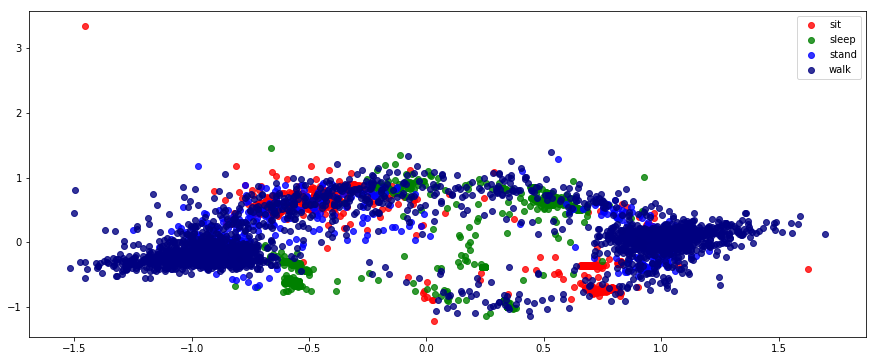

In [14]:
# apply PCA and LDA to X_all and rpy
X_pca_p, pca_p = apply_pca(X_all_p, y_all_p, label_list)
# rpy_pca_p, pca_p = apply_pca(rpy_p, y_all_p, label_list)

# Reshape Data (Pure Label)

In [15]:
# print(rpy_pca_p.shape, y_all_p.shape, subj_all_p.shape)

In [16]:
# get label-separated X and y
X_pure, y_pure = prepare_pure_label(X_pca_p, y_all_p, subj_all_p, all_patients, new_label_list)
y_pure = y_pure.reshape((y_pure.shape[0],))

0 0 (315, 60, 3)
0 1 (315, 60, 3)
0 2 (315, 60, 3)
0 3 (315, 60, 3)
0 4 (315, 60, 3)
0 5 (315, 60, 3)
1 0 (314, 60, 3)
1 1 (315, 60, 3)
1 2 (315, 60, 3)
1 3 (313, 60, 3)
1 4 (321, 60, 3)
1 5 (321, 60, 3)
2 0 (501, 60, 3)
2 1 (514, 60, 3)
2 2 (502, 60, 3)
2 3 (499, 60, 3)
2 4 (502, 60, 3)
2 5 (502, 60, 3)
3 0 (1189, 60, 3)
3 1 (327, 60, 3)
3 2 (315, 60, 3)
3 3 (320, 60, 3)
3 4 (314, 60, 3)
3 5 (308, 60, 3)


In [17]:
print(X_pure.shape, y_pure.shape)

(9582, 180) (9582,)


# Reshape Data (Impure Label)

In [18]:
X_impure, y_impure = prepare_impure_label(X_pca_p, y_all_p)

In [19]:
print(X_impure.shape, y_impure.shape)

(10939, 180) (10939,)


# Split Train and Test Set

In [20]:
# Split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_pure, y_pure, test_size=0.2, random_state=42)

X_tr, X_te, y_tr, y_te = train_test_split(X_impure, y_impure, test_size=0.2, random_state=42)

print(X_tr.shape)
print(X_te.shape)

(8751, 180)
(2188, 180)


In [21]:
print(X_train.shape)
print(X_test.shape)

(7665, 180)
(1917, 180)


# K-Nearest Neighbors

In [22]:
nn_model = nn_classifier(X_train, y_train)
print("Finished training")

Finished training


In [23]:
filename = basepath + 'model/knn_model_patients.pkl'
pickle.dump(nn_model, open(filename, 'wb'))

In [24]:
y_pred = nn_model.predict(X_test)

In [25]:
nn_model_2 = nn_classifier(X_tr, y_tr)
print("Finished training")

Finished training


In [26]:
y_pred_2 = nn_model_2.predict(X_te)

## Evaluation

In [27]:
%run eval_score.ipynb

In [28]:
LABELS = ['sit','sleep','stand','walk']

0.865414710485133


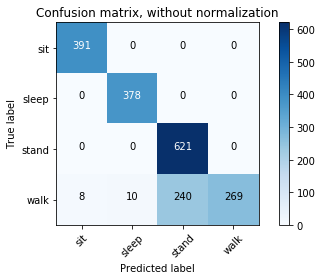

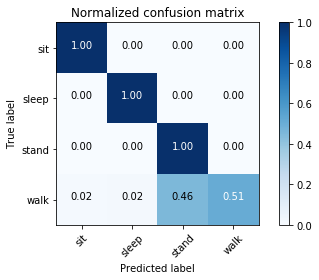

              precision    recall  f1-score   support

         sit       0.98      1.00      0.99       391
       sleep       0.97      1.00      0.99       378
       stand       0.72      1.00      0.84       621
        walk       1.00      0.51      0.68       527

   micro avg       0.87      0.87      0.87      1917
   macro avg       0.92      0.88      0.87      1917
weighted avg       0.90      0.87      0.85      1917



In [29]:
acc = accuracy_score(y_test, y_pred)
print(acc)

show_conf_matrix(y_test, y_pred, LABELS)
show_clf_report(y_test, y_pred, LABELS)

0.8628884826325411


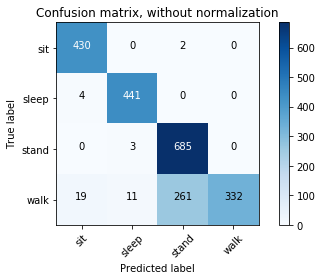

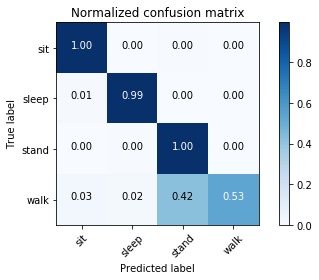

              precision    recall  f1-score   support

         sit       0.95      1.00      0.97       432
       sleep       0.97      0.99      0.98       445
       stand       0.72      1.00      0.84       688
        walk       1.00      0.53      0.70       623

   micro avg       0.86      0.86      0.86      2188
   macro avg       0.91      0.88      0.87      2188
weighted avg       0.90      0.86      0.85      2188



In [30]:
acc = accuracy_score(y_te, y_pred_2)
print(acc)

show_conf_matrix(y_te, y_pred_2, LABELS)
show_clf_report(y_te, y_pred_2, LABELS)

# Walk Algorithm

In [31]:
%run classifier_alg.ipynb

In [32]:
X_dict = {
    'id': subj_all_p,
    'x': [X_i[0] for X_i in X_all_p],
    'y': [X_i[1] for X_i in X_all_p],
    'z': [X_i[2] for X_i in X_all_p],
    'x_pca': [X_i_pca[0] for X_i_pca in X_pca_p],
    'y_pca': [X_i_pca[1] for X_i_pca in X_pca_p],
    'z_pca': [X_i_pca[2] for X_i_pca in X_pca_p],
    'label': y_all_p
}

df_rpy = pd.DataFrame(X_dict)

In [33]:
cols = ['x_pca', 'y_pca', 'z_pca']

df_pca = df_rpy[cols]     # patients

In [34]:
xyz_pca = np.array(df_pca.to_dict(orient='split')['data'])
dummy_y = np.array([-1 for i in range(len(xyz_pca))])

In [35]:
xyz_pca, y_temp = make_overlapping(xyz_pca, dummy_y)

In [36]:
xyz_pca.shape, df_pca.shape

((10939, 60, 3), (10998, 3))

In [37]:
walk_pred = classify_walk_2(xyz_pca)
walk_pred = np.array(walk_pred)

In [38]:
walk_pred

array([0, 0, 0, ..., 3, 3, 3])

In [39]:
walk_pred = np.array(walk_pred)

walk_pred.shape

(10939,)

In [40]:
walk_actual = np.array([3 if (df_rpy.loc[i, 'label']==3) else 0 for i in range(len(df_rpy))])

walk_actual.shape

(10998,)

In [41]:
print(walk_actual)

[0 0 0 ... 3 3 3]


## Walk Algorithm Evaluation

In [42]:
walk_lbl = ['NaN','walk']

0.8999908583965628


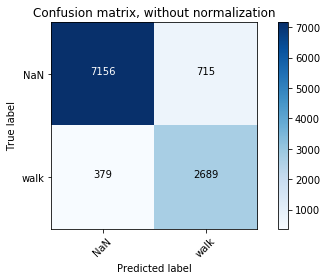

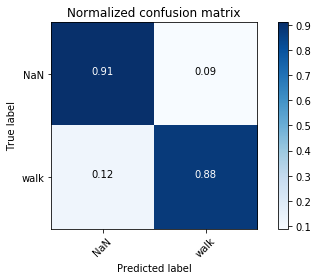

              precision    recall  f1-score   support

         NaN       0.95      0.91      0.93      7871
        walk       0.79      0.88      0.83      3068

   micro avg       0.90      0.90      0.90     10939
   macro avg       0.87      0.89      0.88     10939
weighted avg       0.90      0.90      0.90     10939



In [43]:
acc = accuracy_score(walk_actual[:walk_pred.shape[0]], walk_pred)
print(acc)

show_conf_matrix(walk_actual[:walk_pred.shape[0]], walk_pred, walk_lbl)
show_clf_report(walk_actual[:walk_pred.shape[0]], walk_pred, walk_lbl)

# Combine SVM and Walk Algorithm

In [44]:
X_test_new = get_inverse_X(X_test)

X_test_new

array([[[ 0.96,  0.02,  0.13],
        [ 0.87,  0.02,  0.19],
        [ 0.84, -0.05,  0.19],
        ...,
        [ 1.11,  0.13,  0.23],
        [ 0.91, -0.06,  0.21],
        [ 0.88, -0.05,  0.24]],

       [[-0.55, -0.61,  0.45],
        [-0.54, -0.61,  0.45],
        [-0.55, -0.61,  0.45],
        ...,
        [-0.54, -0.61,  0.45],
        [-0.54, -0.61,  0.45],
        [-0.54, -0.61,  0.45]],

       [[-0.92, -0.13,  0.  ],
        [-0.81, -0.14,  0.02],
        [-1.17, -0.28, -0.  ],
        ...,
        [-1.07, -0.28, -0.07],
        [-0.73, -0.09, -0.05],
        [-0.83, -0.13, -0.03]],

       ...,

       [[-0.19,  0.85, -0.41],
        [-0.19,  0.85, -0.41],
        [-0.19,  0.85, -0.41],
        ...,
        [-0.2 ,  0.85, -0.41],
        [-0.2 ,  0.85, -0.41],
        [-0.2 ,  0.85, -0.41]],

       [[-1.04, -0.22, -0.08],
        [-0.9 , -0.15, -0.05],
        [-0.92, -0.2 , -0.04],
        ...,
        [-1.01, -0.18,  0.01],
        [-0.96, -0.22, -0.01],
        [-0.92,

In [45]:
walk_pred = classify_walk_2(X_test_new)

In [46]:
y_pred_new = combine_2(X_test_new, y_pred)

0.9379238393322901


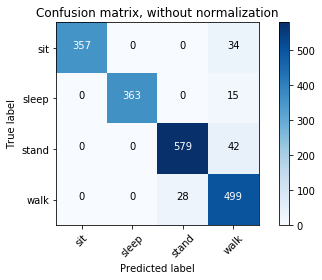

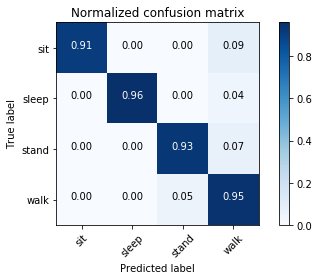

              precision    recall  f1-score   support

         sit       1.00      0.91      0.95       391
       sleep       1.00      0.96      0.98       378
       stand       0.95      0.93      0.94       621
        walk       0.85      0.95      0.89       527

   micro avg       0.94      0.94      0.94      1917
   macro avg       0.95      0.94      0.94      1917
weighted avg       0.94      0.94      0.94      1917



In [47]:
acc = accuracy_score(y_test, y_pred_new)
print(acc)

show_conf_matrix(y_test, y_pred_new, LABELS)
show_clf_report(y_test, y_pred_new, LABELS)

# Test Model with Some Subjects

In [66]:
%run test_model.ipynb

In [67]:
filename = basepath + 'model/knn_model_patients.pkl'

model = pickle.load(open(filename,'rb'))

Loading 3001's data
Finished prediction


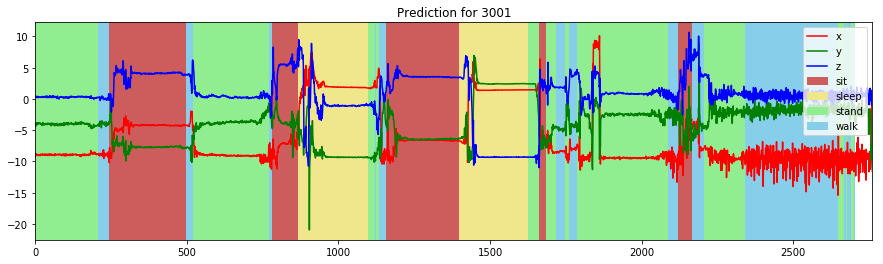

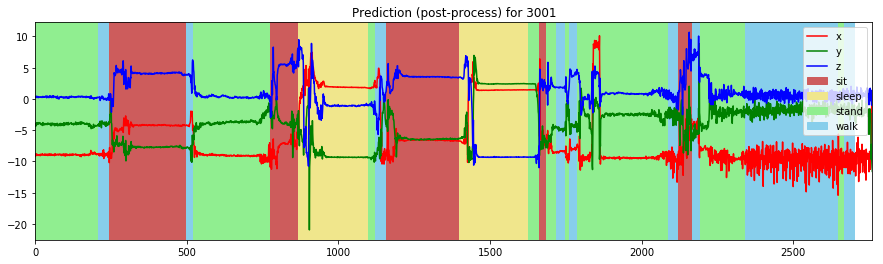

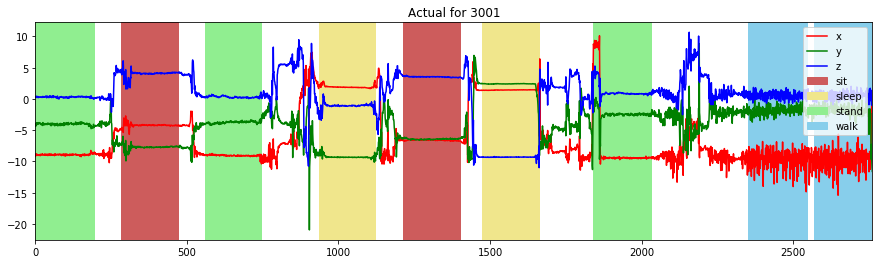

0.9466831990080595


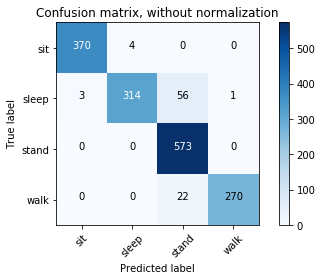

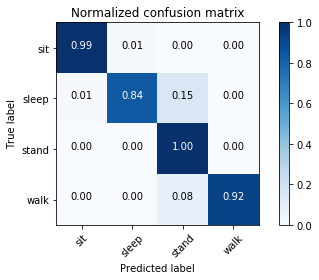

              precision    recall  f1-score   support

         sit       0.99      0.99      0.99       374
       sleep       0.99      0.84      0.91       374
       stand       0.88      1.00      0.94       573
        walk       1.00      0.92      0.96       292

   micro avg       0.95      0.95      0.95      1613
   macro avg       0.96      0.94      0.95      1613
weighted avg       0.95      0.95      0.95      1613

Loading 3002's data


KeyboardInterrupt: 

In [50]:
all_subjects = [str(i) for i in range(3001,3006)]

df_y_all = call_functions(all_subjects, pca_p)

In [ ]:
cols = ['x','y','z']
df_y_all

In [ ]:
LABELS = ['sit', 'sleep', 'stand', 'walk']

df_y_notnull = df_y_all[df_y_all['y_pred']!=-1]
df_y_notnull = df_y_notnull.dropna()
df_y_notnull = df_y_notnull.reset_index(drop=True)

print(df_y_notnull.shape)

actual_y = list(df_y_notnull['y_actual'])
pred_y = list(df_y_notnull['y_pred'])

last = len(pred_y)

for i in range(len(pred_y)):
    if(pred_y[i]==-1):
        last = i
        break

pred_y = pred_y[:last]
actual_y = actual_y[:last]

acc = accuracy_score(actual_y, pred_y)
print(acc)

show_conf_matrix(actual_y, pred_y, LABELS)
show_clf_report(actual_y, pred_y, LABELS)

labels_list = [0,1,2,3]
report = classification_report(actual_y, pred_y, labels_list, output_dict=True)
print(report['macro avg'])

# Segmentation Using Ruptures

In [74]:
person_id = '3001'

Loading 3001's data
Finished prediction


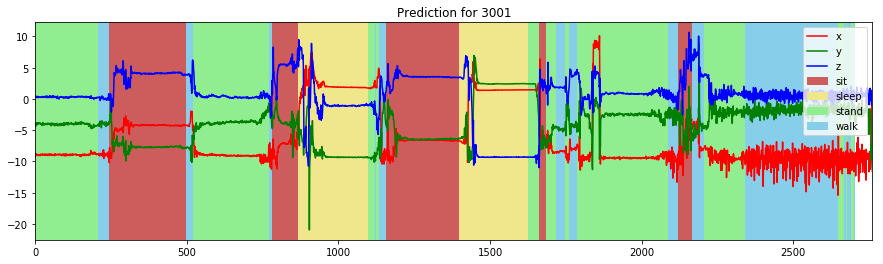

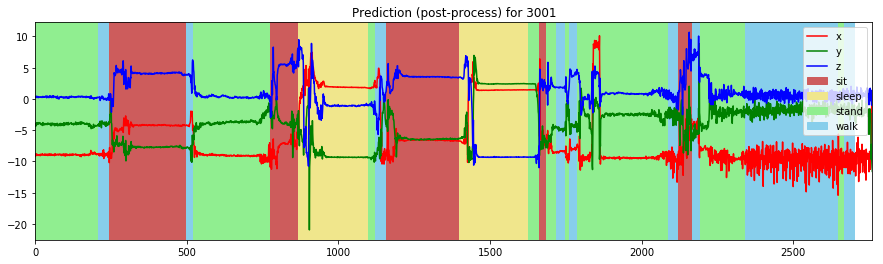

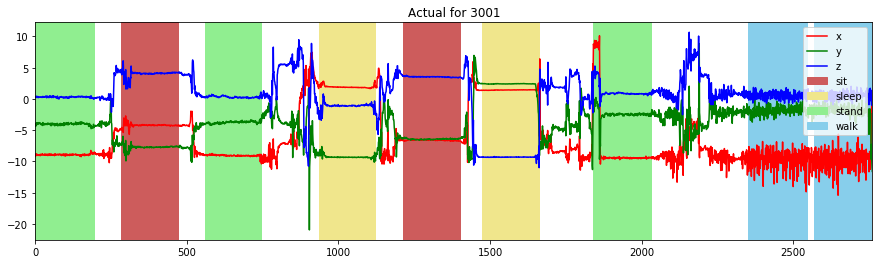

0.9466831990080595


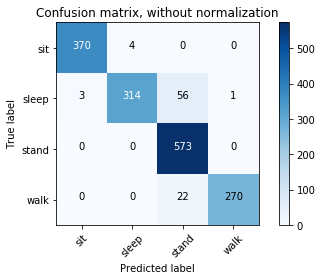

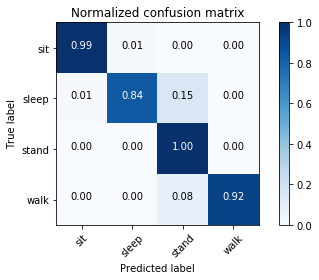

              precision    recall  f1-score   support

         sit       0.99      0.99      0.99       374
       sleep       0.99      0.84      0.91       374
       stand       0.88      1.00      0.94       573
        walk       1.00      0.92      0.96       292

   micro avg       0.95      0.95      0.95      1613
   macro avg       0.96      0.94      0.95      1613
weighted avg       0.95      0.95      0.95      1613



In [68]:
s = person_id
print("Loading {0}'s data".format(s))

df_sid = load_actual_timer(s)
df_test = load_data(s, df_sid)

X_vis_imp, ts_list_imp = preprocess_data(df_test, pca_p)
df_y = predict_combine(X_vis_imp, ts_list_imp)

df_test, df_y = prepare_actual_lb(df_test, df_y, df_sid)

actual_periods = get_actual_periods(df_test)
pred_periods = get_predicted_periods(df_y)
pp_all_run = postprocess_predicted(pred_periods, df_y)

df_y['y_pred'] = pd.Series(pp_all_run)
pp_periods = get_predicted_periods(df_y)
plot_highlighted(s, df_test, pred_periods, pp_periods, actual_periods)

evaluate(df_y)

In [76]:
cols = ['x','y','z']

df_xyz = df_test[cols]

X_one_person = df_xyz.to_dict(orient='split')['data']
X_one_person = np.array(X_one_person)

In [83]:
# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Dynp(model=model, min_size=20, jump=10).fit(X_one_person)

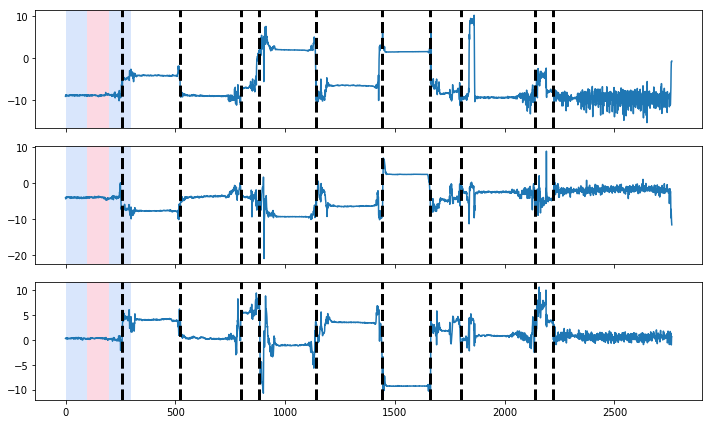

In [89]:
# show results
bkps = [100,200,300]
my_bkps = algo.predict(n_bkps=10)

rpt.show.display(X_one_person, bkps, my_bkps, figsize=(10, 6))
plt.show()

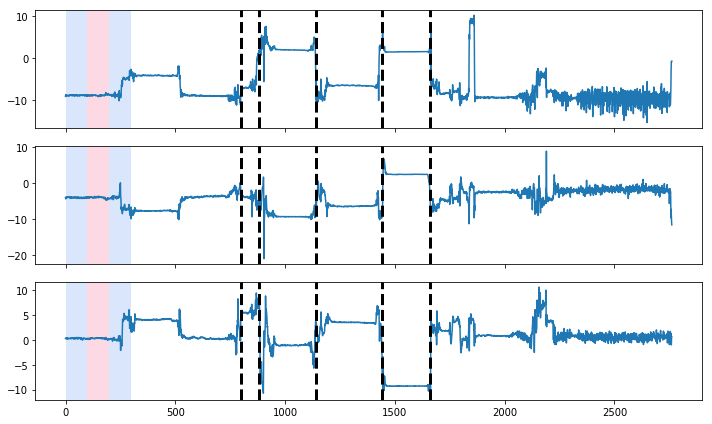

In [90]:
# show results
bkps = [100,200,300]
my_bkps = algo.predict(n_bkps=5)

rpt.show.display(X_one_person, bkps, my_bkps, figsize=(10, 6))
plt.show()